# This notebook assess the predictions of our ML models on the validation data 

### Import the necessary libraries 

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import keras 
from keras.models import Sequential
from keras.layers import Dense 
import tensorflow
#from tensorflow.keras.utils import to_categorical
from keras import layers
#from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Input
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten
from keras import backend as K
from keras.utils import np_utils

from tensorflow.keras.models import load_model

In [2]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
# whats in our dir 

%ls

 Volume in drive C is Windows
 Volume Serial Number is 4051-E7E7

 Directory of C:\Users\Nikhiel\Desktop\validation_set

2023/02/05  16:56    <DIR>          .
2023/02/04  01:55    <DIR>          ..
2023/02/03  15:42    <DIR>          .ipynb_checkpoints
2023/02/02  19:42    <DIR>          __pycache__
2022/11/28  02:11           161ÿ352 ann1.h5
2023/02/03  03:39         3ÿ494ÿ456 ANN1_PR_info.csv
2022/11/06  00:42             2ÿ899 avgph.py
2022/11/28  02:14            72ÿ192 cnn_NET1.h5
2023/02/03  03:41         5ÿ123ÿ244 CNN1_PR_info.csv
2022/11/28  02:15           978ÿ448 cnn2_NET1.h5
2023/02/03  03:40         3ÿ225ÿ639 CNN2_PR_info.csv
2023/02/03  19:16           803ÿ081 PRcurve_plots.html
2023/02/03  19:16           210ÿ863 PRcurve_plots.ipynb
2023/02/03  15:18           963ÿ023 validation_analysis_ann1.ipynb
2023/02/05  15:40           842ÿ235 validation_analysis_cnn1.html
2023/02/05  15:42           244ÿ341 validation_analysis_cnn1.ipynb
2023/02/05  16:56            86ÿ571 validat

###  Define function to produce an individual pulse height 

In [4]:
def single_ph(sigarray):
    #num_sigs = len(sigarray) for this function it will be one - single signal 
    adc = np.sum(sigarray, axis=0)
    timebin = np.arange(0,30,1)
    '''
    for i in range(30):
        
        avg = np.concatenate((np.array(sigarray[i]),
                             np.array(sigarray[i+30]),
                             np.array(sigarray[i+60])), axis=None).sum()/1
        m_adc.append(avg)
        timebin.append(i)
    '''
    #fig, ax = plt.subplots(figsize=(16, 7))
    #plt.figure(figsize=(16, 7))
    #plt.plot(timebin, m_adc, color="royalblue")
    #plt.scatter(timebin, m_adc, color="navy")
    plt.step(timebin, adc, color='royalblue')
    plt.ylabel("ADC", fontsize=13)
    plt.xlabel("Time bin (100ns)", fontsize=13)
    plt.tight_layout()

### load the initial test data 

In [5]:
test = pd.read_csv("validset.csv")

In [6]:
test.head()

,AN00,AN01,AN02,AN03,AN04,AN05,AN06,AN07,AN08,AN09,...,BN21,BN22,BN23,BN24,BN25,BN26,BN27,BN28,BN29,label
0,13,30,39,30,21,36,31,22,16,19,...,15,16,13,13,14,12,14,13,14,0
1,9,9,8,11,7,11,9,12,8,13,...,28,22,20,17,15,13,12,13,12,0
2,80,143,108,71,50,37,32,29,25,25,...,14,17,15,14,14,13,13,15,13,1
3,10,16,16,29,31,22,14,14,13,10,...,21,15,15,16,18,14,16,13,15,0
4,24,41,26,22,24,26,19,19,18,18,...,68,39,29,22,20,20,20,16,14,0


### Modify the cell below if using an ANN 

In [7]:
# Get the signals and labels as arrays 
signals = np.array(test.iloc[:, :90])
labels = np.array(test.label)


In [8]:
labels_ohe = keras.utils.np_utils.to_categorical(labels, 2)

## Now we get the signals and assign to "sigs" variable. Modify the cell below depending on the model used and if normalization and or reshaping is needed or not

In [9]:
sigs = signals.reshape(len(test), 3, 30)/1023


## load the keras model 

In [10]:
mod = load_model('cnn2_NET1.h5')

In [11]:
mod.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convol2D (Conv2D)           (None, 3, 30, 120)        1200      
                                                                 
 maxpool (MaxPooling2D)      (None, 1, 10, 120)        0         
                                                                 
 flatten (Flatten)           (None, 1200)              0         
                                                                 
 dropout (Dropout)           (None, 1200)              0         
                                                                 
 hidden_layer (Dense)        (None, 64)                76864     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 Dense-output (Dense)        (None, 2)                 1

## Predict on the test data using model 

In [12]:
probs = mod.predict(sigs)

In [13]:
from sklearn import metrics

In [14]:
from avgph import *

# Precision -Recall curve 

The above results were obtained from selecting the class that exhibited the greater probability of occurrence amongst the two.
This therefore set the probability threshold to 0.5. We now examine the P-R curve in order to select a threshold that maximizes the AUC-PR of our model.

In [15]:
from sklearn.metrics import precision_recall_curve, auc

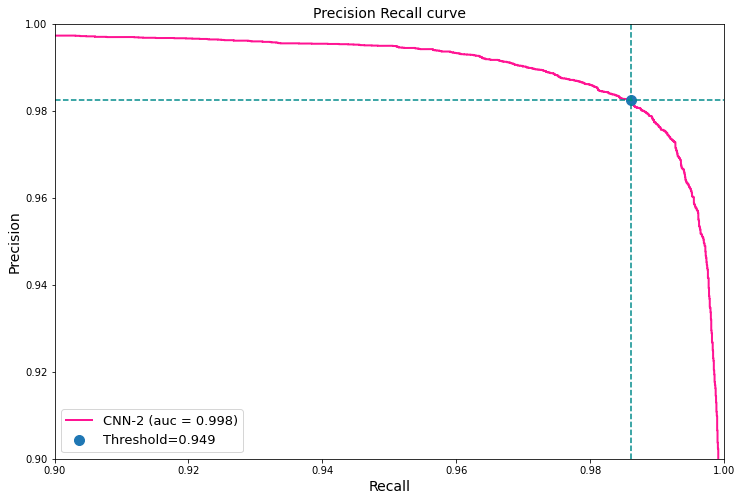

In [16]:
prec_cnn2, rec_cnn2, thres_cnn2 = precision_recall_curve(labels_ohe[:, 1].ravel(), probs[:,1].ravel())
pr_auc_cnn2=auc(rec_cnn2, prec_cnn2)

df_pr = pd.DataFrame({'Prec':prec_cnn2[:-1], 
                     'Rec':rec_cnn2[:-1],
                     'thres':thres_cnn2})
df_pr['AUC'] = pr_auc_cnn2
#df_pr['approx_area'] = df_pr['Prec']*df_pr['Rec']
df_pr['dist'] = np.sqrt(((1-df_pr['Prec'])**2)+((1-df_pr['Rec'])**2))

ind = np.where(df_pr['dist']==df_pr['dist'].min())[0][0]




plt.figure(figsize=(12, 8))
plt.plot(df_pr['Rec'], df_pr['Prec'], label='CNN-2 (auc = {:.3f})'.format(pr_auc_cnn2), color='deeppink', linewidth=2)
plt.plot(df_pr.Rec[ind], df_pr.Prec[ind], marker='o', linestyle='', 
         label='Threshold={:.3f}'.format(df_pr.thres[ind]), markersize=10)

plt.axvline(df_pr['Rec'][ind], color='darkcyan', linestyle='--')
plt.axhline(df_pr['Prec'][ind], color='darkcyan', linestyle='--')
plt.title("Precision Recall curve",fontsize=14)
plt.xlabel("Recall",fontsize=14)
plt.ylabel("Precision",fontsize=14)
plt.xlim(0.9,1)
plt.ylim(0.9,1)
plt.legend(fontsize=13)
plt.show()

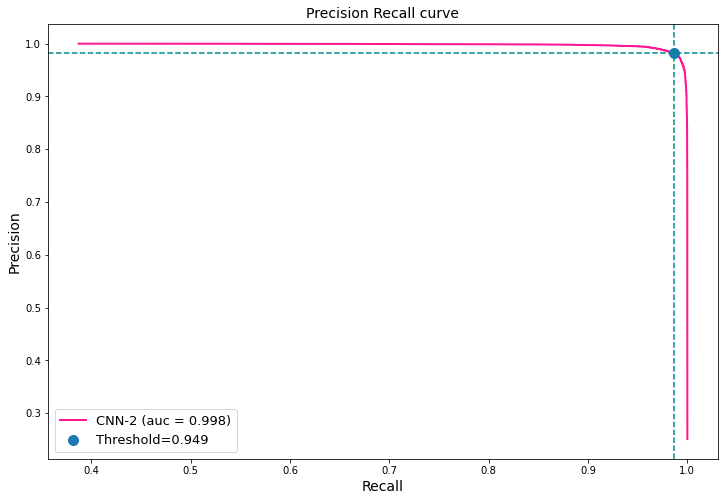

In [17]:
plt.figure(figsize=(12, 8))
plt.plot(df_pr['Rec'], df_pr['Prec'], label='CNN-2 (auc = {:.3f})'.format(pr_auc_cnn2), color='deeppink', linewidth=2)
plt.plot(df_pr.Rec[ind], df_pr.Prec[ind], marker='o', linestyle='', 
         label='Threshold={:.3f}'.format(df_pr.thres[ind]), markersize=10)

plt.axvline(df_pr['Rec'][ind], color='darkcyan', linestyle='--')
plt.axhline(df_pr['Prec'][ind], color='darkcyan', linestyle='--')
plt.title("Precision Recall curve",fontsize=14)
plt.xlabel("Recall",fontsize=14)
plt.ylabel("Precision",fontsize=14)
#plt.xlim(0.7,1)
#plt.ylim(0.7,1)
plt.legend(fontsize=13)
plt.show()

### Now apply the threshold and re-analyse all

In [18]:

# save the pr curve info as a csv file 
#df_pr.to_csv("CNN2_PR_info.csv", index=False)




In [19]:
# Compute the new predictions based on the prob thresh of 0.6

thres_preds = np.zeros(len(probs))

thres_preds[probs[:,1]>=0.949] = 1


### Confusion matrix of thresholded predictions 

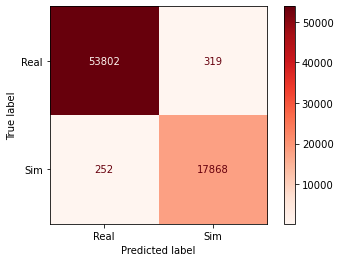

In [20]:
ConfusionMatrixDisplay.from_predictions(
    labels, thres_preds, cmap='Reds', display_labels=['Real', 'Sim']
)
plt.show()

In [21]:
t_Prec = metrics.precision_score(labels, thres_preds, pos_label=1)
t_Sens = metrics.recall_score(labels, thres_preds, pos_label=1)
#Spec = metrics.recall_score(labels, preds, pos_label=1)
t_F1 = metrics.f1_score(labels, thres_preds, pos_label=1)
t_Acc = metrics.accuracy_score(labels, thres_preds)


print('Precision = {}'.format(t_Prec))
print('Sensitivity = {}'.format(t_Sens))
#print('Specificity = {}'.format(Spec))
print('F1 = {}'.format(t_F1))
print('Accuracy = {}'.format(t_Acc))

Precision = 0.9824599989003134
Sensitivity = 0.9860927152317881
F1 = 0.9842730052056078
Accuracy = 0.9920959012195291


In [22]:
from sklearn.metrics import confusion_matrix

In [23]:
tn, fp, fn, tp = confusion_matrix(labels, thres_preds, labels=[0, 1]).ravel()

t_Spec = tn/(tn + fp)
t_missrate = fn/(fn + tp) 
print('Specificity = {}'.format(t_Spec))
print('Miss rate / FNR  = {}'.format(t_missrate))


Specificity = 0.9941057999667412
Miss rate / FNR  = 0.01390728476821192


In [24]:
confusion_matrix(labels, thres_preds, labels=[0, 1])

array([[53802,   319],
       [  252, 17868]], dtype=int64)

In [25]:
def PH_recon(truth, modelprobs, probthresh, sigdata):
    
     
    # First make predict the classes based on our threshold and the probs that our model outputs
    classpreds = np.zeros(len(sigdata))
    classpreds[modelprobs[:,1] >= probthresh] = 1
    
    
    # Now find the subset of the sigdata that are misclassifications based on our predictions 
    
    
    # find out where misclassifications occur (indices)
    #-------------------------------------------------

    misclass = np.where(truth!=classpreds)[0]
    #misclass_probs = modelprobs[misclass]
    misclass_labs = truth[misclass]
    #misclass_preds = classpreds[misclass]

    misclass_sigs = sigdata[misclass]
    #-------------------------------------------------
    
    
    # Further subset the misclassified signals to find the FALSE NEGATIVES 
    
    # Here the preds = 0 but the true labels = 1

    # This is a subset of the misclass 

    #------------------------------------------------------------------------------------
    # where in the misclassified labels is the labels 1 
    fn_locs = np.where(misclass_labs == 1)[0]  # these are locations of truly sim sigs 

    #misclass_labsfn = misclass_labs[fn_locs] 
    #misclass_predfn = misclass_preds[fn_locs]

    #misclass_probsfn = misclass_probs[fn_locs]

    misclass_sigsfn = misclass_sigs[fn_locs]
    #------------------------------------------------------------------------------------
    
    
    # make a data frame of the False negatives 
    df_Fn = pd.DataFrame(misclass_sigsfn)
    
    #from avgph import *
    
    # get the PH info as arrays for the FALSE NEGATIVES
    tfn, adc_fn = pharray(df_Fn)
    
    
    
    # get the PH info as arrays for all the Misclassifications 
    tfmc, adc_mc = pharray(pd.DataFrame(misclass_sigs))
    
    
    
    #==================================================
    # Finally return all 4 arrays in a certain order 
    #==================================================
    
    
    return tfn, adc_fn, tfmc, adc_mc
    
    

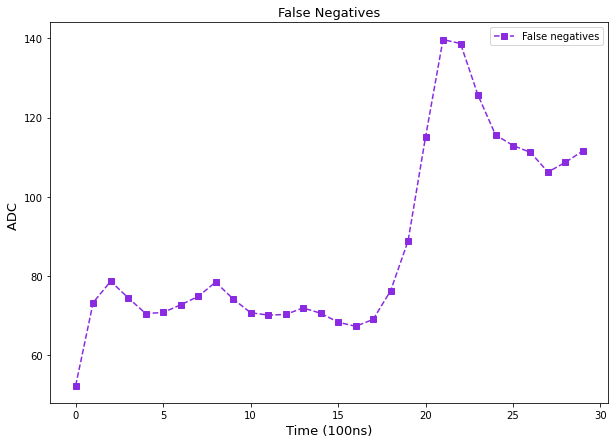

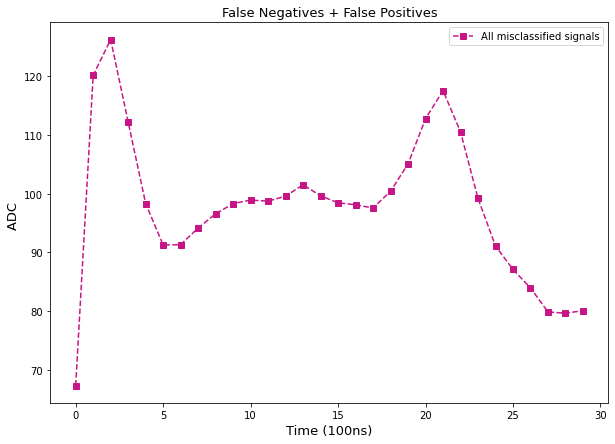

In [26]:
time_fn, adc_fn, time_fnfp, adc_fnfp = PH_recon(truth = labels, modelprobs = probs, probthresh = 0.949, sigdata=signals)


plt.figure(figsize=(10, 7))
plt.plot(time_fn, adc_fn, color='blueviolet', linestyle='--', marker='s', label="False negatives")
plt.xlabel("Time (100ns)", fontsize=13)
plt.ylabel('ADC ', fontsize=13)
plt.title("False Negatives", fontsize=13)
plt.legend()
plt.show()



plt.figure(figsize=(10, 7))
plt.plot(time_fnfp, adc_fnfp, color='mediumvioletred', linestyle='--', marker='s', label="All misclassified signals")
plt.xlabel("Time (100ns)", fontsize=13)
plt.ylabel('ADC ', fontsize=13)
plt.title("False Negatives + False Positives", fontsize=13)
plt.legend()
plt.show()